# Birmingham City Council - Purchase Card Transactions

In this dataset you have a collection of purchase card transactions for the Birmingham City Council. https://data.birmingham.gov.uk/dataset/purchase-card-transactions. This is a historical dataset, you’re able to perform any of the following tasks:
	
- (Clustering) Discovering profiles (whether the case) or unusual transactions  
(anomalies detection) ...  

- (Forecasting) Try to guess future transactional behaviors. For instance, what would be the next purchase? Expenditures forecasting? ...  

- (Creativity) State a problem.


It’s up to you defining the time window in which your analysis will take place.

To do so, we suggest you create a notebook, like Jupyter (if you use python) or a Rmarkdown report (in case you use R) and make it available.
 
Hint to success in your quest:  
Develop and state clear of the data science process you'll perform over the dataset and highlight important aspects you might consider affordable to discuss over. Use the mindset of a business and curious consultant.

# Considerations
The origin of our dataset is a municipal chamber.
The data are distributed in excel spreadsheets, 1 per month from 2014 to 2018, with a few months missing.  

Opening 1 of the files, it can be verified that the records contain transactions per person, which will be identified by the end of the credit card, the transaction is accompanied by the value, date, and identifiers of the supplier and classifiers of the activity and type of product of this supplier.

As we have a dataset of corporate cards, perhaps the council interest is to discover corporate frauds such as purchases of products with overpriced values, and forecasts of expenses per person.

# 1 - Goals
- Discover profiles: clustering by people / clustering by product type / unusual transactions.  

-	Guess future transactional behaviours / forecasting.

# 2 - Data management

-	Imported data by year in different DataFrames.
-	Indexed the rows by the dates using “TRANS DATE” variable
-	Added the year 2015 in the name of the corresponding files.


## System setup

In [1]:
import os
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from numpy import array
from numpy import hstack
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from joblib import dump,load
import h5py
import dill

In [103]:
#import dill
def notebook_export_variables():
    dill.dump_session('notebook_env.db')

def notebook_import_variables():
    dill.load_session('notebook_env.db')

#from joblib import dump,load
#import h5py

def dumpfiles_export():
    hf = h5py.File('np_data.h5', 'w')
    hf.create_dataset('card_tr', data = card_tr)
    hf.create_dataset('normal_original_gross_amt', data = normal_original_gross_amt)
    hf.create_dataset('ocsvm_decision_func', data = ocsvm_decision_func)
    hf.create_dataset('ocsvm_score', data = ocsvm_score)
    hf.create_dataset('predictions', data = predictions)
    print(hf.keys())
    hf.close()

def dumpfiles_import():
    hf = h5py.File('np_data.h5', 'r')
    print(hf.keys())
    card_tr = np.array(hf.get('card_tr'))
    normal_original_gross_amt = np.array(hf.get('normal_original_gross_amt'))
    ocsvm_decision_func = np.array(hf.get('ocsvm_decision_func'))
    ocsvm_score = np.array(hf.get('ocsvm_score'))
    predictions = np.array(hf.get('predictions'))
    hf.close()

#import pandas
def df_files_export():
    anomaly.to_pickle('anomaly.pkl')
    df.to_pickle('df.pkl')
    df_aux.to_pickle('df_aux.pkl')
    df_clust.to_pickle('df_clust.pkl')
    card_data.to_pickle('card_data.pkl')
    card_trans.to_pickle('card_trans.pkl')
    card_vc.to_pickle('card_vc.pkl')
    merchant.to_pickle('merchant.pkl')
    merchant_data.to_pickle('merchant_data.pkl')
    merchant_trans.to_pickle('merchant_trans.pkl')
    merchant_vc.to_pickle('merchant_vc.pkl')

def df_files_import():
    anomaly = pd.read_pickle('anomaly.pkl')
    df = pd.read_pickle('df.pkl')
    df_clust = pd.read_pickle('df_clust.pkl')
    df_aux = pd.read_pickle('df_aux.pkl')
    card_data = pd.read_pickle('card_data.pkl')
    card_trans = pd.read_pickle('card_trans.pkl')
    card_vc = pd.read_pickle('card_vc.pkl')
    merchant = pd.read_pickle('merchant.pkl')
    merchant_data = pd.read_pickle('merchant_data.pkl')
    merchant_trans = pd.read_pickle('merchant_trans.pkl')
    merchant_vc = pd.read_pickle('merchant_vc.pkl')
    
def project_root():
    print(os.listdir())
    cwd = os.chdir("./notebooks/Dataset")
    print(os.listdir())

## Dataset import

### Util functions

In [3]:
mo_list = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]

In [4]:
def xlsDataImport(file_list, key):
  df = pd.DataFrame()
  mi_list = mo_list.copy()
  counter = 0
  for pos, filename in enumerate(file_list): 
    if filename.endswith(".xls") and key in filename:
      counter+=1
      df = df.append(pd.read_excel(filename, index_col = 'TRANS DATE', parse_dates = True))
      print(counter,pos,filename)
      for mo in mi_list:
        #if mo in filename or mo[1:3] in filename:
          if mo in filename:
            mi_list.remove(mo)
  print("missing months", mi_list)
  return df

I downloaded all the spreadsheets from the link provided, to avoid problems with future data unavailability, and made it available in a compressed file in my github repository.
No spreadsheets have been changed in content or name.

In [5]:
project_root()

['.git', '.gitignore', '.idea', '.ipynb_checkpoints', '.vscode', 'BirminghamCC_PurchaseCardTransactions.ipynb', 'data', 'Dataset', 'env', 'models', 'notebooks', 'np_data.h5', 'README.md']
['anomaly.pkl', 'card_data.pkl', 'card_trans.pkl', 'card_vc.pkl', 'cusersfinainmndesktoppublish-copy-january-2017.xls', 'cusersfinainmndesktoppublish-spend-april-2017.xls', 'cusersfinainmndesktoppublish-spend-august-2017-all-directorates.xls', 'cusersfinainmndesktoppublish-spend-february-2017-all-directorates.xls', 'cusersfinainmndesktoppublish-spend-january-2018.xls', 'cusersfinainmndesktoppublish-spend-july-2017.xls', 'cusersfinainmndesktoppublish-spend-june--2017.xls', 'cusersfinainmndesktoppublish-spend-march-2017.xls', 'cusersfinainmndesktoppublish-spend-may-2017.xls', 'cusersfinainmndesktoppublish-spend-november-2017-all-directorates.xls', 'cusersfinainmndesktoppublish-spend-october-2017-all-directorates.xls', 'cusersfinainmndesktoppublish-spend-sept-2017.xls', 'df.pkl', 'df_aux.pkl', 'df_clust.

In [10]:
!wget https://github.com/ddlandim/DS-BirminghamCardTransactions/raw/main/Dataset/Dataset.zip

'wget' nao ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


In [10]:
!rm *.xls

In [9]:
!unzip Dataset.zip

'unzip' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


In [6]:
print(os.listdir())
files_list = os.listdir()

['anomaly.pkl', 'card_data.pkl', 'card_trans.pkl', 'card_vc.pkl', 'cusersfinainmndesktoppublish-copy-january-2017.xls', 'cusersfinainmndesktoppublish-spend-april-2017.xls', 'cusersfinainmndesktoppublish-spend-august-2017-all-directorates.xls', 'cusersfinainmndesktoppublish-spend-february-2017-all-directorates.xls', 'cusersfinainmndesktoppublish-spend-january-2018.xls', 'cusersfinainmndesktoppublish-spend-july-2017.xls', 'cusersfinainmndesktoppublish-spend-june--2017.xls', 'cusersfinainmndesktoppublish-spend-march-2017.xls', 'cusersfinainmndesktoppublish-spend-may-2017.xls', 'cusersfinainmndesktoppublish-spend-november-2017-all-directorates.xls', 'cusersfinainmndesktoppublish-spend-october-2017-all-directorates.xls', 'cusersfinainmndesktoppublish-spend-sept-2017.xls', 'df.pkl', 'df_aux.pkl', 'df_clust.pkl', 'itemisedtransactionsaugust2015publishspendalldirectorates.xls', 'itemisedtransactionsjuly2015publishspend.xls', 'merchant.pkl', 'merchant_data.pkl', 'merchant_trans.pkl', 'merchant_

### 2014
Importing files

In [7]:
df2014 = xlsDataImport(files_list,"2014")

1 45 purchasecardsdec2014.xls
2 46 purchasecardsnov2014.xls
3 47 purchasecardtransactionsapril2014.xls
4 48 purchasecardtransactionsaugust2014.xls
5 49 purchasecardtransactionsjuly2014.xls
6 50 purchasecardtransactionsjune2014.xls
7 51 purchasecardtransactionsmay2014.xls
8 52 purchasecardtransactionsoctober2014.xls
9 53 purchasecardtransactionsseptember2014.xls
missing months ['january', 'february', 'march', 'november', 'december']


2014 files start in April and as we can see november and december have their names abbreviated so we can move on

In [8]:
df2014

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,BILLING CUR CODE,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,,
2014-12-11,VR,53.21,shell kings 587,************5770,GBP,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities
2014-12-09,VR,53.12,tesco pfs 2484,************8143,GBP,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities
2014-12-09,VR,64.81,bush service station,************2997,GBP,K020,Vehicle Fuel,RV1K1,Elders Group - Erdington,A00,Adult & Communities
2014-12-12,VR,34.50,esso perry barr service s,************2997,GBP,K020,Vehicle Fuel,RV1K1,Elders Group - Erdington,A00,Adult & Communities
2014-12-15,VR,76.17,shell aqueduct,************2997,GBP,K020,Vehicle Fuel,RV1K1,Elders Group - Erdington,A00,Adult & Communities
...,...,...,...,...,...,...,...,...,...,...,...
2014-09-09,VR,49918.10,the furnishing service,************6583,GBP,L100,Equip Operational,RYB5F,Social Fund,A00,Corporate Resources
2014-09-05,VR,46667.53,the furnishing service,************6583,GBP,L100,Equip Operational,RYB5F,Social Fund,A00,Corporate Resources
2014-09-24,VR,446.10,the furnishing service,************5339,GBP,L100,Equip Operational,RVB0A,Harriet Louisa Loxton Trust(ex5000,A00,Adults & Comms


### 2015
importing files

In [9]:
df2015 = xlsDataImport(files_list,"2015")

1 19 itemisedtransactionsaugust2015publishspendalldirectorates.xls
2 20 itemisedtransactionsjuly2015publishspend.xls
3 34 publishedspenddecember2015.xls
4 38 publishspendjune2015alldirectorates.xls
5 40 publishspendnovember2015.xls
6 41 publishspendoctober2015.xls
7 44 publishspendseptember2015.xls
8 54 purchaseccardtransactionsjanuary2015.xls
9 55 svlrdclr05homesharechexefinainmngeneralappublishspendmay2015.xls
missing months ['february', 'march', 'april']


missing: 
 - feb (present in datafiles, but without '2015' in filename)
 - mar (present in datafiles, but without '2015' in filename)
 - apr (not present in datafiles provided)

 manual include of feb,mar

In [10]:
df2015

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,Directorate
TRANS DATE,,,,,,,,,,,
2015-08-04,VR,50.32,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN
2015-09-01,VR,50.76,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN
2015-08-11,VR,20.01,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN
2015-08-14,VR,80.50,esso perry barr service s,************2997,K020,Vehicle Fuel,RV1K1,Elders Group - Erdington,A00,Adult & Communities,NaN
2015-08-18,VR,55.00,malthurst petroleu,************5804,K020,Vehicle Fuel,RVA12,Enablement Tyburn Rd,A00,Adult & Communities,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2015-05-11,VR,52.57,jacksons services ltd,************4599,K020,Vehicle Fuel,RHNCA,Careline,A00,NaN,Local Services
2015-06-01,VR,61.93,esso aston way ss,************4599,K020,Vehicle Fuel,RHNCA,Careline,A00,NaN,Local Services
2015-05-06,VR,78.18,tesco pay at pump 4203,************6665,K020,Vehicle Fuel,RHEE7,Ladywood CBH05 Neigh C'takers,A00,NaN,Local Services


In [11]:
df2015_feb = pd.read_excel('publishspendpurchasecardsfebruary.xls', index_col = 'TRANS DATE', parse_dates = True)
df2015_mar = pd.read_excel('publishspendpurchasecardsmarch.xls', index_col = 'TRANS DATE', parse_dates = True)

In [12]:
df2015_feb

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Unnamed: 10
TRANS DATE,,,,,,,,,,
2015-02-24,VR,54.75,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities
2015-02-03,VR,51.64,tesco pfs 2484,************8738,K020,Vehicle Fuel,RV11Y,"Marsh Lane Dce, 79, B23",A00,Adult & Communities
2015-02-12,VR,43.89,tesco pfs 2484,************8738,K020,Vehicle Fuel,RV11Y,"Marsh Lane Dce, 79, B23",A00,Adult & Communities
2015-02-04,VR,54.00,blood pressure ass,************7557,H2T0,Training Other,RVA0K,Admin Support,A00,Adult & Communities
2015-02-07,VZ,6.99,viewbix,************7557,H000,Staff Advert Exp,RVA0K,Admin Support,A00,Adult & Communities
...,...,...,...,...,...,...,...,...,...,...
2015-02-04,VR,40.05,tesco pfs 3953,************8527,K020,Vehicle Fuel,RHBC7,Erdington CBH03 Neigh C'takers,A00,Local Services
2015-02-19,VR,82.65,tesco pfs 3953,************8527,K020,Vehicle Fuel,RHBC7,Erdington CBH03 Neigh C'takers,A00,Local Services
2015-03-02,VR,83.59,tesco pfs 4203,************6790,K020,Vehicle Fuel,RHEE7,Ladywood CBH05 Neigh C'takers,A00,Local Services


In [13]:
df2015_feb.rename(columns={"Unnamed: 10" : "Directorate"})

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
2015-02-24,VR,54.75,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities
2015-02-03,VR,51.64,tesco pfs 2484,************8738,K020,Vehicle Fuel,RV11Y,"Marsh Lane Dce, 79, B23",A00,Adult & Communities
2015-02-12,VR,43.89,tesco pfs 2484,************8738,K020,Vehicle Fuel,RV11Y,"Marsh Lane Dce, 79, B23",A00,Adult & Communities
2015-02-04,VR,54.00,blood pressure ass,************7557,H2T0,Training Other,RVA0K,Admin Support,A00,Adult & Communities
2015-02-07,VZ,6.99,viewbix,************7557,H000,Staff Advert Exp,RVA0K,Admin Support,A00,Adult & Communities
...,...,...,...,...,...,...,...,...,...,...
2015-02-04,VR,40.05,tesco pfs 3953,************8527,K020,Vehicle Fuel,RHBC7,Erdington CBH03 Neigh C'takers,A00,Local Services
2015-02-19,VR,82.65,tesco pfs 3953,************8527,K020,Vehicle Fuel,RHBC7,Erdington CBH03 Neigh C'takers,A00,Local Services
2015-03-02,VR,83.59,tesco pfs 4203,************6790,K020,Vehicle Fuel,RHEE7,Ladywood CBH05 Neigh C'takers,A00,Local Services


In [14]:
df2015_mar

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
2015-03-08,VR,35.96,fasthosts internet,************3497,L9Y0,Computing Other,RV3VG,AD Adults Strategy,A00,Adult & Communities
2015-03-23,VR,12.24,fast key services,************4094,L100,Equip Operational,RV3A7,Hodge Hill Adult Team,A00,Adult & Communities
2015-03-22,VR,52.45,acocks green 224,************4302,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities
2015-03-09,VR,40.66,esso aston way ss,************6316,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities
2015-03-29,VR,59.57,esso aston way ss,************1287,K020,Vehicle Fuel,RV14R,Mobile Night Care Service,A00,Adult & Communities
...,...,...,...,...,...,...,...,...,...,...
2015-03-31,VR,66.95,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,Local Services
2015-03-31,VR,25.90,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,Local Services
2015-03-31,VR,19.18,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,Local Services


In [15]:
df2015 = df2015.append(df2015_feb)
df2015 = df2015.append(df2015_mar)
df2015

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,Directorate,Unnamed: 10
TRANS DATE,,,,,,,,,,,,
2015-08-04,VR,50.32,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN,NaN
2015-09-01,VR,50.76,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN,NaN
2015-08-11,VR,20.01,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN,NaN
2015-08-14,VR,80.50,esso perry barr service s,************2997,K020,Vehicle Fuel,RV1K1,Elders Group - Erdington,A00,Adult & Communities,NaN,NaN
2015-08-18,VR,55.00,malthurst petroleu,************5804,K020,Vehicle Fuel,RVA12,Enablement Tyburn Rd,A00,Adult & Communities,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-31,VR,66.95,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,NaN,Local Services,NaN
2015-03-31,VR,25.90,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,NaN,Local Services,NaN
2015-03-31,VR,19.18,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,NaN,Local Services,NaN


In [16]:
df2015 = df2015.iloc[:, :-2]
df2015

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
2015-08-04,VR,50.32,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities
2015-09-01,VR,50.76,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities
2015-08-11,VR,20.01,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities
2015-08-14,VR,80.50,esso perry barr service s,************2997,K020,Vehicle Fuel,RV1K1,Elders Group - Erdington,A00,Adult & Communities
2015-08-18,VR,55.00,malthurst petroleu,************5804,K020,Vehicle Fuel,RVA12,Enablement Tyburn Rd,A00,Adult & Communities
...,...,...,...,...,...,...,...,...,...,...
2015-03-31,VR,66.95,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,NaN
2015-03-31,VR,25.90,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,NaN
2015-03-31,VR,19.18,selco trade centres,************3949,J030,Bldg RM Departmental,RLBCC,Alexander Stadium,A00,NaN


### 2016
January to December

In [17]:
df2016 = xlsDataImport(files_list,"2016")

1 26 publish-spend-april-2016.xls
2 27 publish-spend-august-2016.xls
3 28 publish-spend-december-2016.xls
4 29 publish-spend-july-2016.xls
5 30 publish-spend-june-2016.xls
6 31 publish-spend-may-2016.xls
7 32 publish-spend-october-2016.xls
8 33 publish-spend-september-2016.xls
9 35 publishing-spend-november-2016.xls
10 36 publishspendfebruary2016.xls
11 37 publishspendjanuary2016.xls
12 39 publishspendmarch2016.xls
missing months []


In [18]:
df2016

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,Directorates
TRANS DATE,,,,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN
2016-04-11,VR,50.00,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN
2016-04-19,VR,60.98,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN
2016-04-28,VR,59.68,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities,NaN
2016-04-06,VR,30.01,malthurst petroleu,************5804,K020,Vehicle Fuel,RVA12,Enablement Tyburn Rd,A00,Adult & Communities,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2016-03-07,VR,71.00,travelodge website,************7751,M900,Hospitality,RHNCA,Careline,A00,Local Services,NaN
2016-03-07,VR,71.00,travelodge website,************7751,M900,Hospitality,RHNCA,Careline,A00,Local Services,NaN
2016-03-06,VR,39.00,travelodge website,************7751,M900,Hospitality,RHNCA,Careline,A00,Local Services,NaN


In [19]:
df2016 = df2016.drop('Directorates',axis=1)
df2016

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
2016-04-11,VR,50.00,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities
2016-04-19,VR,60.98,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities
2016-04-28,VR,59.68,tex sussex sstn,************8738,K020,Vehicle Fuel,RV12T,"Shakti Elders Dce, 73 Conybere St, B12",A00,Adult & Communities
2016-04-06,VR,30.01,malthurst petroleu,************5804,K020,Vehicle Fuel,RVA12,Enablement Tyburn Rd,A00,Adult & Communities
...,...,...,...,...,...,...,...,...,...,...
2016-03-07,VR,71.00,travelodge website,************7751,M900,Hospitality,RHNCA,Careline,A00,Local Services
2016-03-07,VR,71.00,travelodge website,************7751,M900,Hospitality,RHNCA,Careline,A00,Local Services
2016-03-06,VR,39.00,travelodge website,************7751,M900,Hospitality,RHNCA,Careline,A00,Local Services


### 2017
January to December

In [20]:
df2017 = xlsDataImport(files_list,"2017")

1 4 cusersfinainmndesktoppublish-copy-january-2017.xls
2 5 cusersfinainmndesktoppublish-spend-april-2017.xls
3 6 cusersfinainmndesktoppublish-spend-august-2017-all-directorates.xls
4 7 cusersfinainmndesktoppublish-spend-february-2017-all-directorates.xls
5 9 cusersfinainmndesktoppublish-spend-july-2017.xls
6 10 cusersfinainmndesktoppublish-spend-june--2017.xls
7 11 cusersfinainmndesktoppublish-spend-march-2017.xls
8 12 cusersfinainmndesktoppublish-spend-may-2017.xls
9 13 cusersfinainmndesktoppublish-spend-november-2017-all-directorates.xls
10 14 cusersfinainmndesktoppublish-spend-october-2017-all-directorates.xls
11 15 cusersfinainmndesktoppublish-spend-sept-2017.xls
missing months ['september', 'december']


missing: december is provided as csv file with different features, so for now we bypass this file, april is not provided and sept is abreviated

In [21]:
df2017

,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,BILLING CUR CODE,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,Directorates,TRANS TAX AMT,BILLING CUR CODE.1
TRANS DATE,,,,,,,,,,,,,,,,
2017-01-03,VR,72.61,GBP,72.61,GBP,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN,NaN,NaN
2017-01-24,VR,85.51,GBP,85.51,GBP,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN,NaN,NaN
2017-02-01,VR,10.09,GBP,10.09,GBP,shell fiveways 387,************1147,K020,Vehicle Fuel,RV1K2,Elders Group - Ladywood,A00,Adult & Communities,NaN,NaN,NaN
2017-01-04,VR,20.00,GBP,20.00,GBP,mibsons service st,************5804,K020,Vehicle Fuel,RVA12,Enablement Tyburn Rd,A00,Adult & Communities,NaN,NaN,NaN
2017-01-05,VR,50.00,GBP,50.00,GBP,malthurst petroleu,************5804,K020,Vehicle Fuel,RVA12,Enablement Tyburn Rd,A00,Adult & Communities,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-09-07,VR,22885.25,GBP,22885.25,GBP,the furnishing service,************6583,L100,Equip Operational,RYB5F,Social Fund,A00,Corporate Resources,NaN,3814.21,GBP
2017-09-07,VR,29596.54,GBP,29596.54,GBP,the furnishing service,************6583,L100,Equip Operational,RYB5F,Social Fund,A00,Corporate Resources,NaN,4932.76,GBP
2017-09-29,VR,19625.42,GBP,19625.42,GBP,the furnishing service,************6583,L100,Equip Operational,RYB5F,Social Fund,A00,Corporate Resources,NaN,3270.90,GBP


### 2018
January

In [22]:
df2018 = xlsDataImport(files_list,"2018")

1 8 cusersfinainmndesktoppublish-spend-january-2018.xls
missing months ['february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']


In [23]:
df2018

,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,BILLING CUR CODE,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,,,,
2018-01-03,VR,82.20,GBP,82.20,GBP,mrh six ways,************5804,K020,Vehicle Fuel,RVA11,Beeches GOLDD,A00,Adult Social Care and Health
2018-02-05,VR,60.00,GBP,60.00,GBP,malthurst limited,************5804,K020,Vehicle Fuel,RVA11,Beeches GOLDD,A00,Adult Social Care and Health
2018-01-29,VR,50.00,GBP,50.00,GBP,beeches road servi,************5804,K020,Vehicle Fuel,RVA11,Beeches GOLDD,A00,Adult Social Care and Health
2018-01-19,VR,45.00,GBP,45.00,GBP,beeches road servi,************5804,K020,Vehicle Fuel,RVA11,Beeches GOLDD,A00,Adult Social Care and Health
2018-01-18,VR,77.49,GBP,77.49,GBP,rontec moseley,************2823,K020,Vehicle Fuel,RV191,Moseley Day Centre,A00,Adult Social Care and Health
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-10,VR,63.83,GBP,63.83,GBP,bp clock f/s,************4599,K020,Vehicle Fuel,RHNCA,Careline,A00,Local Services
2018-02-02,VR,34.64,GBP,34.64,GBP,sparkbrook service,************4599,K020,Vehicle Fuel,RHNCA,Careline,A00,Local Services
2018-01-24,VR,48.01,GBP,48.01,GBP,malthurst limited,************2150,K020,Vehicle Fuel,RTG15,Enforcement Team,A00,Local Services


# 3 -	Pre-processing

Profiling / clustering
Based on people's transactions

-	Remove rows containing NaN values.
-	 Ordered values by the ascending dates.
-	Scaled the numerical variables so they will have a means of 0 and a standard deviation of 1.


### Entire dataset

So now we have this dataframes:  
- df2014
- df2015
- df2016
- df2017
- df2018

In [24]:
df2014.head(1)

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,BILLING CUR CODE,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,,
2014-12-11,VR,53.21,shell kings 587,************5770,GBP,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities


In [25]:
df2015.head(1)

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
2015-08-04,VR,50.32,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities


In [26]:
df2016.head(1)

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [27]:
df2017.head(1)

,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,BILLING CUR CODE,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,Directorates,TRANS TAX AMT,BILLING CUR CODE.1
TRANS DATE,,,,,,,,,,,,,,,,
2017-01-03,VR,72.61,GBP,72.61,GBP,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN,NaN,NaN


In [28]:
df2017.drop('Directorates', axis=1, inplace=True)
df2017.head(1)

,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,BILLING CUR CODE,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,TRANS TAX AMT,BILLING CUR CODE.1
TRANS DATE,,,,,,,,,,,,,,,
2017-01-03,VR,72.61,GBP,72.61,GBP,shell kings 587,************5770,K020,Vehicle Fuel,RV12N,African-Caribbean DC,A00,Adult & Communities,NaN,NaN


In [29]:
df2018.head(1)

,TRANS VAT DESC,ORIGINAL GROSS AMT,ORIGINAL CUR,BILLING GROSS AMT,BILLING CUR CODE,MERCHANT NAME,CARD NUMBER,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,,,,
2018-01-03,VR,82.2,GBP,82.2,GBP,mrh six ways,************5804,K020,Vehicle Fuel,RVA11,Beeches GOLDD,A00,Adult Social Care and Health


In [30]:
df_2014 = df2014.copy()
df_2015 = df2015.copy()
df_2016 = df2016.copy()
df_2017 = df2017.copy()
df_2018 = df2018.copy()

# # Dropping rows that contain NULL values from all DataFrames
df_2014 = df_2014.dropna()
df_2015 = df_2015.dropna()
df_2016 = df_2016.dropna()
df_2017 = df_2017.dropna()
df_2018 = df_2018.dropna()

# # Standardizing the ORIGINAL GROSS AMT variable
df_2014_orig_gross_amt= pd.DataFrame(df_2014['ORIGINAL GROSS AMT'].values.reshape(-1, 1))
df_2015_orig_gross_amt= pd.DataFrame(df_2015['ORIGINAL GROSS AMT'].values.reshape(-1, 1))
df_2016_orig_gross_amt= pd.DataFrame(df_2016['ORIGINAL GROSS AMT'].values.reshape(-1, 1))
df_2017_orig_gross_amt= pd.DataFrame(df_2017['ORIGINAL GROSS AMT'].values.reshape(-1, 1))
df_2018_orig_gross_amt= pd.DataFrame(df_2018['ORIGINAL GROSS AMT'].values.reshape(-1, 1))

df_2014['ORIGINAL GROSS AMT'] = StandardScaler().fit_transform(df_2014_orig_gross_amt)
df_2015['ORIGINAL GROSS AMT'] = StandardScaler().fit_transform(df_2015_orig_gross_amt)
df_2016['ORIGINAL GROSS AMT'] = StandardScaler().fit_transform(df_2016_orig_gross_amt)
df_2017['ORIGINAL GROSS AMT'] = StandardScaler().fit_transform(df_2017_orig_gross_amt)
df_2018['ORIGINAL GROSS AMT'] = StandardScaler().fit_transform(df_2018_orig_gross_amt)

# # Sorting values by date
df_2014 = df_2014.sort_values(by = 'TRANS DATE')
df_2015 = df_2015.sort_values(by = 'TRANS DATE')
df_2016 = df_2016.sort_values(by = 'TRANS DATE')
df_2017 = df_2017.sort_values(by = 'TRANS DATE')
df_2018 = df_2018.sort_values(by = 'TRANS DATE')

In [31]:
dataset = [df_2014,df_2015,df_2016,df_2017,df_2018]
for df in dataset:
  print(df.shape)

(33776, 11)
(2050, 10)
(43973, 10)
(4061, 15)
(4999, 13)


In [32]:
df = pd.concat(dataset)
df

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,BILLING CUR CODE,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate,Directorate,ORIGINAL CUR,BILLING GROSS AMT,TRANS TAX AMT,BILLING CUR CODE.1
TRANS DATE,,,,,,,,,,,,,,,,
2013-11-12,VR,-0.383017,www.pcc.nhs.uk/eventma,************7557,GBP,L100,Equip Operational,RVA0K,Admin Support,A00,Adult & Communities,NaN,NaN,NaN,NaN,NaN
2014-03-06,VR,-0.032900,bp snax 24 weoley castle,************5353,GBP,K020,Vehicle Fuel,RHAAC,E'baston CBHO 1 C'takers,A00,Local Services,NaN,NaN,NaN,NaN,NaN
2014-03-27,VZ,-0.087957,asda home delivery,************9410,GBP,L220,Purchases Food,REAJP,Perry Common Junior & Infant,A00,CYP&F SCHOOLS,NaN,NaN,NaN,NaN,NaN
2014-04-01,VR,-0.034620,bp snax 24 cofton 859,************5044,GBP,K020,Vehicle Fuel,RHF03,Northfield Hsg Mgmt,A00,Local Services,NaN,NaN,NaN,NaN,NaN
2014-04-02,VZ,0.253315,court yard rosebank,************0984,GBP,H0T0,Conference Fees Subs Foreign,TA-00847-01,Support To Projects With Partner Cities,A00,Corporate Resources,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-05,VR,2.766636,travelodge gb0000,************6316,GBP,M900,Hospitality,RJADC,Homeless Private Sector Accom,A00,Local Services,NaN,GBP,2996.6,NaN,NaN
2018-02-05,VR,2.769951,travelodge gb0000,************6316,GBP,M900,Hospitality,RJADC,Homeless Private Sector Accom,A00,Local Services,NaN,GBP,3000.0,NaN,NaN
2018-02-05,VR,2.742848,travelodge gb0000,************6316,GBP,M900,Hospitality,RJADC,Homeless Private Sector Accom,A00,Local Services,NaN,GBP,2972.2,NaN,NaN


In [33]:
df.shape

(88859, 16)

In [34]:
df = df.iloc[:, :-5]
df

,TRANS VAT DESC,ORIGINAL GROSS AMT,MERCHANT NAME,CARD NUMBER,BILLING CUR CODE,TRANS CAC CODE 1,TRANS CAC DESC 1,TRANS CAC CODE 2,TRANS CAC DESC 2,TRANS CAC CODE 3,Directorate
TRANS DATE,,,,,,,,,,,
2013-11-12,VR,-0.383017,www.pcc.nhs.uk/eventma,************7557,GBP,L100,Equip Operational,RVA0K,Admin Support,A00,Adult & Communities
2014-03-06,VR,-0.032900,bp snax 24 weoley castle,************5353,GBP,K020,Vehicle Fuel,RHAAC,E'baston CBHO 1 C'takers,A00,Local Services
2014-03-27,VZ,-0.087957,asda home delivery,************9410,GBP,L220,Purchases Food,REAJP,Perry Common Junior & Infant,A00,CYP&F SCHOOLS
2014-04-01,VR,-0.034620,bp snax 24 cofton 859,************5044,GBP,K020,Vehicle Fuel,RHF03,Northfield Hsg Mgmt,A00,Local Services
2014-04-02,VZ,0.253315,court yard rosebank,************0984,GBP,H0T0,Conference Fees Subs Foreign,TA-00847-01,Support To Projects With Partner Cities,A00,Corporate Resources
...,...,...,...,...,...,...,...,...,...,...,...
2018-02-05,VR,2.766636,travelodge gb0000,************6316,GBP,M900,Hospitality,RJADC,Homeless Private Sector Accom,A00,Local Services
2018-02-05,VR,2.769951,travelodge gb0000,************6316,GBP,M900,Hospitality,RJADC,Homeless Private Sector Accom,A00,Local Services
2018-02-05,VR,2.742848,travelodge gb0000,************6316,GBP,M900,Hospitality,RJADC,Homeless Private Sector Accom,A00,Local Services


now we can stardadize entire dataset that contains only the same features in all years provided

In [49]:
#taking the smallest df in features, and fitting DF to this features
df.info()
print(np.setdiff1d(df.columns.values , df_2016.columns.values))
df = df.drop(np.setdiff1d(df.columns.values , df_2016.columns.values),axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88859 entries, 2013-11-12 to 2018-02-05
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TRANS VAT DESC      88859 non-null  object 
 1   ORIGINAL GROSS AMT  88859 non-null  float64
 2   MERCHANT NAME       88859 non-null  object 
 3   CARD NUMBER         88859 non-null  object 
 4   BILLING CUR CODE    42836 non-null  object 
 5   TRANS CAC CODE 1    88859 non-null  object 
 6   TRANS CAC DESC 1    88859 non-null  object 
 7   TRANS CAC CODE 2    88859 non-null  object 
 8   TRANS CAC DESC 2    88859 non-null  object 
 9   TRANS CAC CODE 3    88859 non-null  object 
 10  Directorate         86809 non-null  object 
dtypes: float64(1), object(10)
memory usage: 10.2+ MB
['BILLING CUR CODE']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88859 entries, 2013-11-12 to 2018-02-05
Data columns (total 10 columns):
 #   Column              Non-Null Co

## Exploratory analysis

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88859 entries, 2013-11-12 to 2018-02-05
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TRANS VAT DESC      88859 non-null  object 
 1   ORIGINAL GROSS AMT  88859 non-null  float64
 2   MERCHANT NAME       88859 non-null  object 
 3   CARD NUMBER         88859 non-null  object 
 4   TRANS CAC CODE 1    88859 non-null  object 
 5   TRANS CAC DESC 1    88859 non-null  object 
 6   TRANS CAC CODE 2    88859 non-null  object 
 7   TRANS CAC DESC 2    88859 non-null  object 
 8   TRANS CAC CODE 3    88859 non-null  object 
 9   Directorate         86809 non-null  object 
dtypes: float64(1), object(9)
memory usage: 9.5+ MB


In [52]:
# Analyse the original gross amt variable;

df['ORIGINAL GROSS AMT'].describe()

count    8.885900e+04
mean    -3.438407e-18
std      1.000006e+00
min     -4.390105e+00
25%     -8.315798e-02
50%     -6.771329e-02
75%     -4.016232e-02
max      6.367468e+01
Name: ORIGINAL GROSS AMT, dtype: float64

In [53]:
df['TRANS VAT DESC'].value_counts()

VR       44280
VZ       43857
VE         393
VL         202
VS         112
VT          10
6.65%        5
Name: TRANS VAT DESC, dtype: int64

In [54]:
df['MERCHANT NAME'].value_counts()

amazon uk marketplace     6951
amazon mktplce eu-uk      4113
amazon uk retail          2662
amazon eu                 1977
travelodge website        1290
                          ... 
ramada brimingham city       1
paypal packtypes             1
www.millerandcartergif       1
www.sugarrays.co.uk          1
paypal fancydress4           1
Name: MERCHANT NAME, Length: 9985, dtype: int64

In [55]:
df['TRANS CAC CODE 1'].value_counts()

L100    16205
K020    12241
L220     9751
L030     6167
MC70     5356
        ...  
J240        1
J0A0        1
N040        1
L0F0        1
J0Z0        1
Name: TRANS CAC CODE 1, Length: 123, dtype: int64

In [56]:
df['TRANS CAC DESC 1'].value_counts()

Equip Operational       16205
Vehicle Fuel            12241
Purchases Food           9751
Books                    6167
Supplies & Sev Mic       5356
                        ...  
HEALTH AUTHORITIES          1
HR&M Door Entry             1
AMO - Lighting              1
Dir Payts - Children        1
Graveliner/Concrete         1
Name: TRANS CAC DESC 1, Length: 123, dtype: int64

In [57]:
df['TRANS CAC CODE 2'].value_counts()

RUF0F                   7197
REAAB                   2262
RV014                   1598
RJADC                   1426
RLBMC                   1179
                        ... 
RDP7A                      1
RLR18                      1
RT001                      1
RV0C4                      1
TA-01483-01-4-002-02       1
Name: TRANS CAC CODE 2, Length: 1224, dtype: int64

In [58]:
df['TRANS CAC DESC 2'].value_counts()

Illegal Money Lending T Stds Comm Inv.    7197
The City of Birmingham School             2262
Camborne House HLDC                       1598
Homeless Private Sector Accom             1426
Technical Unit                            1179
                                          ... 
Transport User Pest Control                  1
Boldmere Junior                              1
11-14 Cannon St/7 Fore St                    1
Emergency Planning Fund                      1
Cherry St Grenville Bldg                     1
Name: TRANS CAC DESC 2, Length: 1213, dtype: int64

In [59]:
df['TRANS CAC CODE 3'].value_counts()

A00    87927
A5F      796
A46       54
A8H       17
A42       14
A9Y        7
A7N        7
A95        7
A09        2
A05        2
A8F        2
A02        2
A01        2
A06        2
A10        2
A07        2
A13        2
A11        2
A03        2
A08        2
A12        2
A04        2
A7M        2
Name: TRANS CAC CODE 3, dtype: int64

Text(0, 0.5, 'ORIGINAL GROSS AMT')

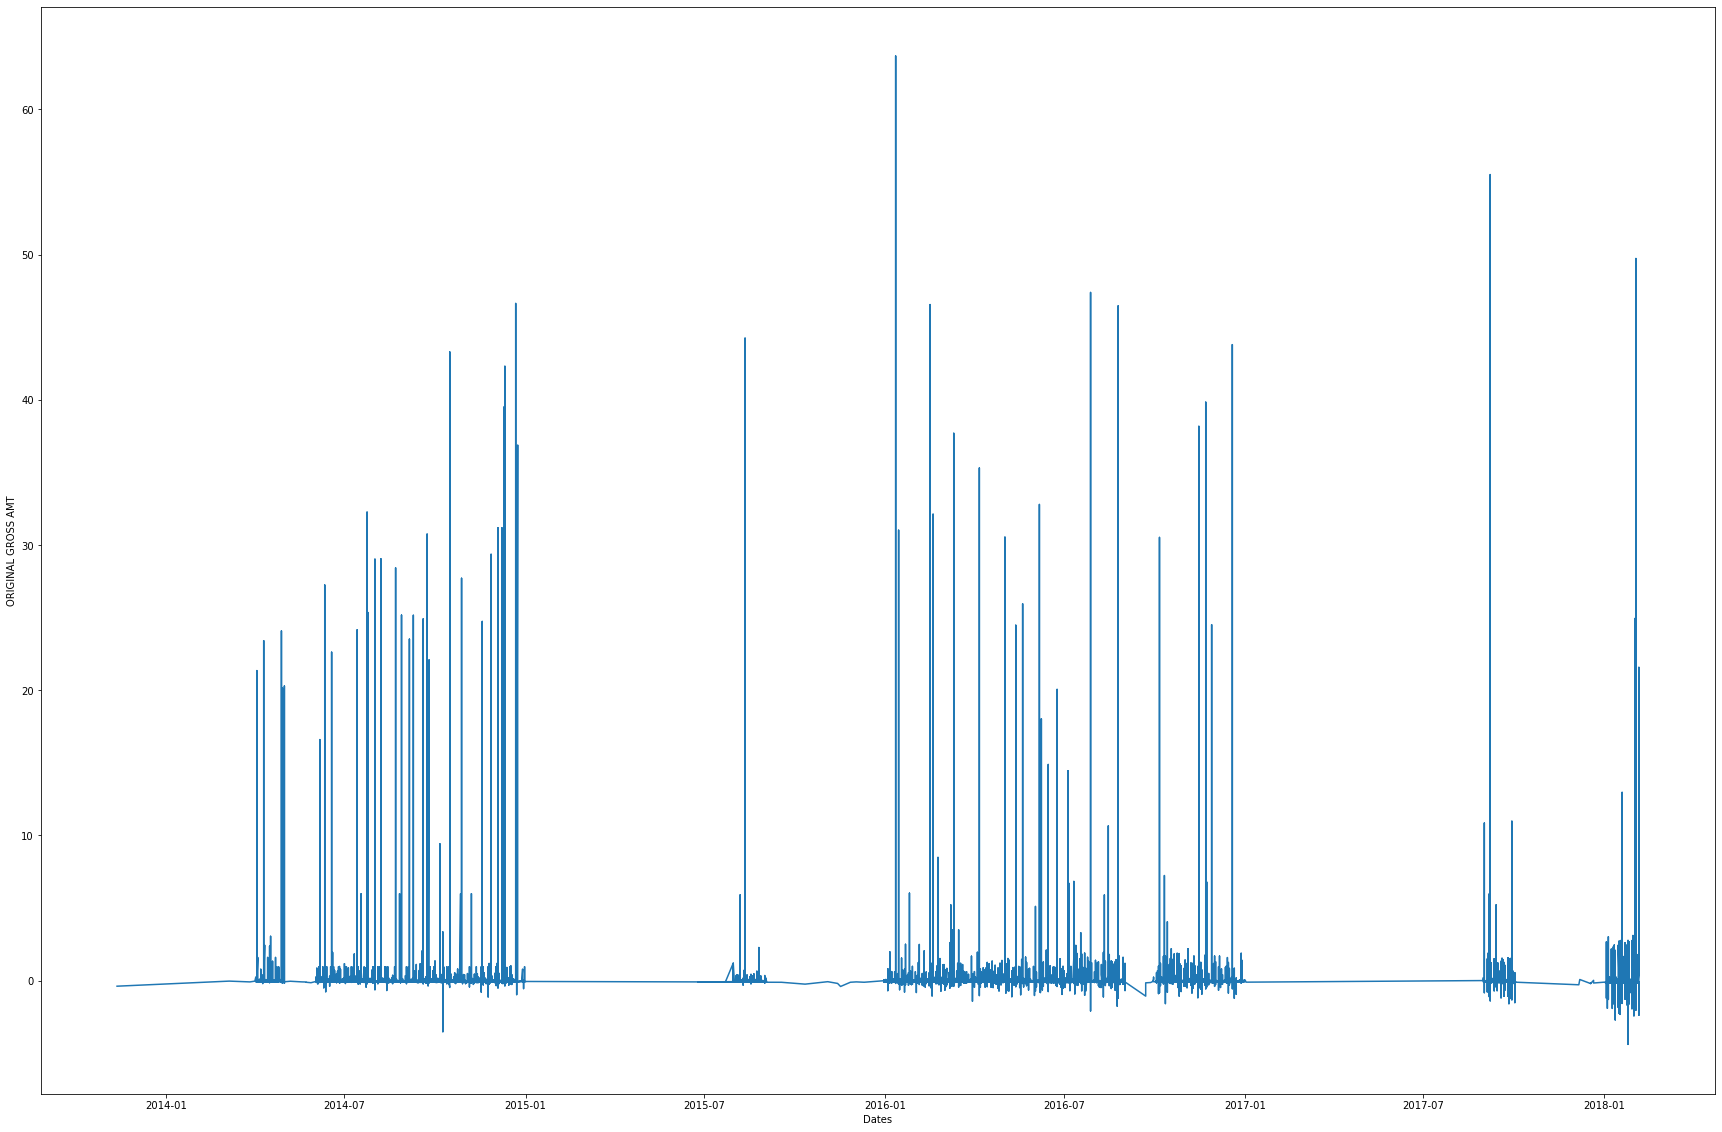

In [60]:
plt.figure(figsize=(30,20))
plt.plot(df['ORIGINAL GROSS AMT'])
plt.xlabel('Dates')
plt.ylabel('ORIGINAL GROSS AMT')

# 4 - Profiling / clustering for 2017-2018

#### Based on card number

In [62]:
### Converting categorical variables about cards into numerical ones
df_aux = df_2016
# Frequency of transactions made by each unique card
card_vc = df_aux['CARD NUMBER'].value_counts()

# Transforming it into a DataFrame
card_vc = pd.DataFrame(card_vc)
card_vc = card_vc.reset_index()
card_vc.columns = ['unique_card','counts']

In [63]:
card_vc

,unique_card,counts
0,************6740,426
1,************2968,389
2,************6308,309
3,************8192,303
4,************8343,301
...,...,...
1002,************2116,1
1003,************0754,1
1004,************0184,1
1005,************7201,1


In [64]:
df_aux['CARD NUMBER']

TRANS DATE
2015-06-25    ************6158
2015-09-18    ************4193
2015-10-12    ************0381
2015-11-04    ************7587
2015-11-14    ************0381
                    ...       
2017-01-02    ************3044
2017-01-02    ************7939
2017-01-02    ************7379
2017-01-02    ************5492
2017-01-02    ************3088
Name: CARD NUMBER, Length: 43973, dtype: object

In [65]:
len(df_aux['CARD NUMBER'])
print(df_aux['CARD NUMBER'][0])
print(card_vc['unique_card'][0])
print(df_aux['ORIGINAL GROSS AMT'][0])
print(card_vc['counts'][0])

print('m iterations = ', len(card_vc['unique_card']))
print('i iterations = ', len(df_aux['CARD NUMBER']))

************6158
************6740
-0.0996825804229481
426
m iterations =  1007
i iterations =  43973


In [66]:
# Average amount of transactions by each unique card
sum_tr = 0
card_trans = pd.DataFrame()
j = 0
for m in card_vc['unique_card']:
  for i in range(len(df_aux['CARD NUMBER'])):
    if df_aux['CARD NUMBER'][i] == m:
      sum_tr += df_aux['ORIGINAL GROSS AMT'][i]
  card_trans = card_trans.append([(sum_tr/card_vc['counts'][j])])
  j += 1

# Assembling previous data
card_data = pd.DataFrame()
card_data['card_name'] = card_vc['unique_card']
card_data['trans_avg'] = card_trans.values.reshape(-1,1)
card_data['frequency'] = card_vc['counts']

card_data = card_data.set_index(card_data.card_name)
card_data = card_data.drop(['card_name'], axis = 1)

card_data

,trans_avg,frequency
card_name,,
************6740,-5.520294e-02,426
************2968,1.824278e-02,389
************6308,4.345319e-01,309
************8192,4.012053e-01,303
************8343,3.350376e-01,301
...,...,...
************2116,-3.414770e-01,1
************0754,9.659991e-02,1
************0184,1.715483e-03,1


Text(0, 0.5, 'Cluster inertia')

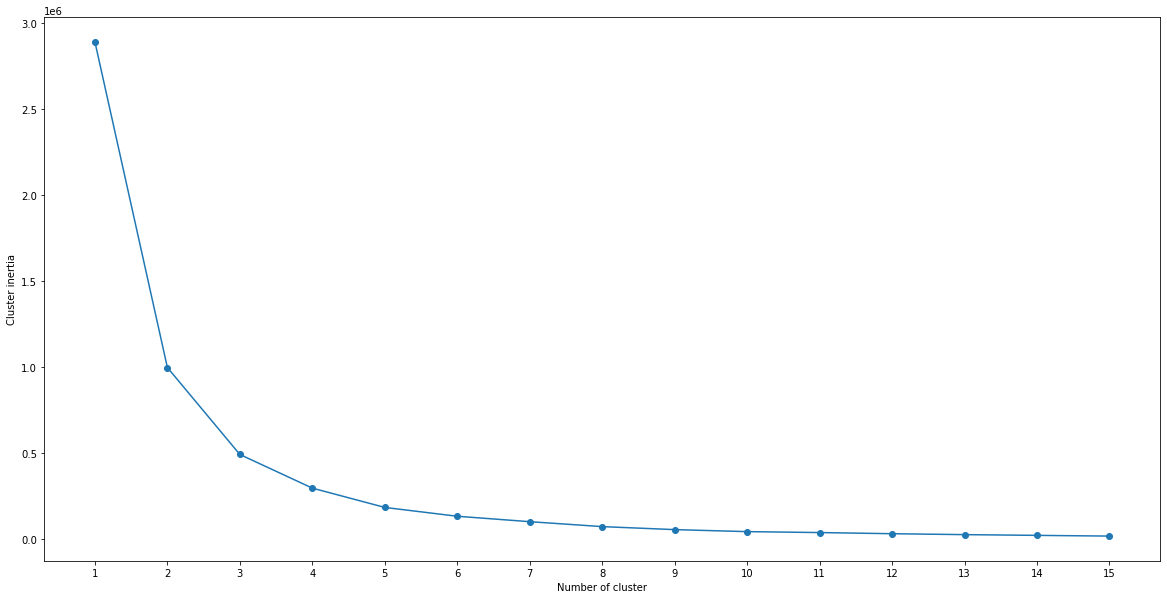

In [67]:
# Scaling the frequency of transactions by means amount of transactions
card_tr = card_data.values

# First we need to determine the optimal number of clusters
cluster_range = range(1,16)
cluster_error = []

for num in cluster_range:
    model = KMeans(num)
    model.fit(card_tr)
    cluster_error.append(model.inertia_)

df_clust = pd.DataFrame({'cluster_number':cluster_range,'cluster_error':cluster_error})


plt.figure(figsize=(20,10))
plt.xticks(range(1,16))
plt.plot(df_clust.cluster_number,df_clust.cluster_error, marker="o")
plt.xlabel("Number of cluster")
plt.ylabel("Cluster inertia")

Text(0, 0.5, 'The average transactions made by each person')

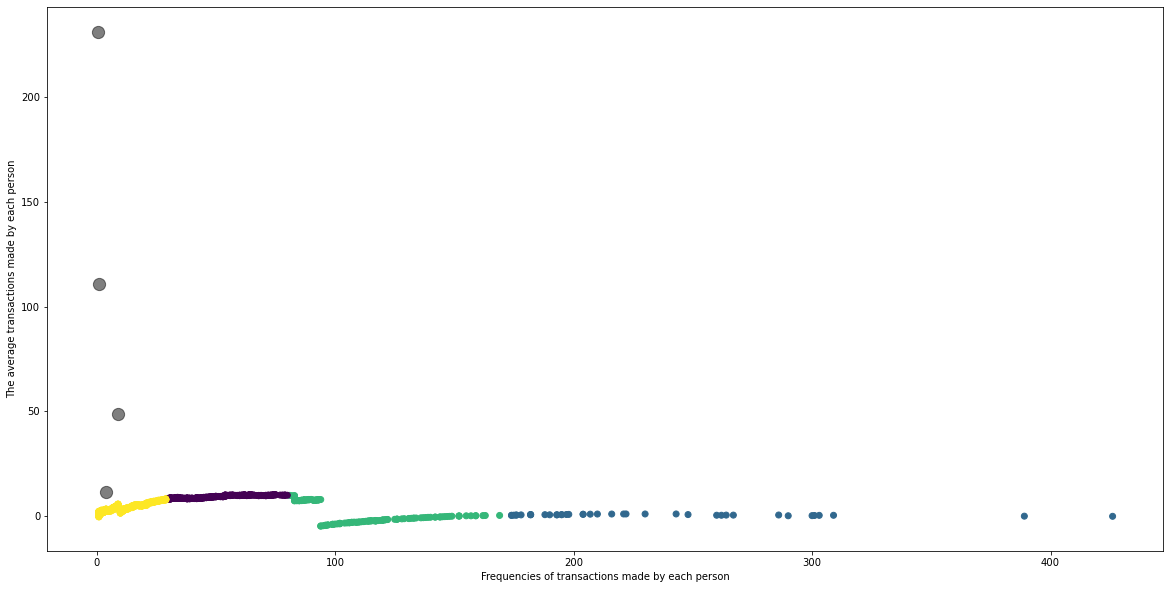

In [68]:
# The elbow graph showed us that 4 clusters is the optimal number
# so we'll start implementing the code

kmeans_model = KMeans(n_clusters=4)
kmeans_model.fit(card_tr)
kmeans_predict = kmeans_model.predict(card_tr)
kmeans_centroids = kmeans_model.cluster_centers_

plt.figure(figsize=(20,10))
plt.scatter(card_tr[:,1],card_tr[:,0], c=kmeans_predict)
plt.scatter(kmeans_centroids[:,0], kmeans_centroids[:,1], c='black', s=150, alpha=0.5)
plt.xlabel('Frequencies of transactions made by each person')
plt.ylabel('The average transactions made by each person')

#### Based on merchants

In [69]:
### Converting categorical variables about marchants into numerical ones

# Frequency of transactions made in favor of ech unique merchant
merchant_vc = df_aux['MERCHANT NAME'].value_counts()

# Transforming it into a DataFrame
merchant = pd.DataFrame(merchant_vc)
merchant = merchant.reset_index()
merchant.columns = ['unique_merchant','counts']
merchant

,unique_merchant,counts
0,amazon uk marketplace,5837
1,amazon uk retail,2182
2,travelodge website,1270
3,asda home shopping,858
4,amazon uk retail amazon.c,583
...,...,...
5879,bootsferndown,1
5880,estimote.com,1
5881,rapid racking ltd,1
5882,halfords 0820,1


In [70]:
print(len(df_aux['MERCHANT NAME']))
print(df_aux['MERCHANT NAME'][0])
print(df_aux['ORIGINAL GROSS AMT'][0])
print(merchant['counts'][0])

print('m iterations = ', len(merchant['unique_merchant']))
print('i iterations = ', len(df_aux['MERCHANT NAME']))

43973
the consortium/wms
-0.0996825804229481
5837
m iterations =  5884
i iterations =  43973


In [71]:
sum_tr = 0
merchant_trans = pd.DataFrame()
j = 0

# Average amount of transactions for each unique merchant
for m in merchant['unique_merchant']:
  for i in range(len(df_aux['MERCHANT NAME'])):
    if df_aux['MERCHANT NAME'][i] == m:
      sum_tr += df_aux['ORIGINAL GROSS AMT'][i]
  merchant_trans = merchant_trans.append([(sum_tr/merchant['counts'][j])])
  j += 1

# Assembling previous data
merchant_data = pd.DataFrame()
merchant_data['merchant_name'] = merchant['unique_merchant']
merchant_data['trans_avg'] = merchant_trans.values.reshape(-1,1)
merchant_data['frequency'] = merchant['counts']

merchant_data = merchant_data.set_index(merchant_data.merchant_name)
merchant_data = merchant_data.drop(['merchant_name'], axis = 1)

merchant_data

,trans_avg,frequency
merchant_name,,
amazon uk marketplace,-7.646016e-02,5837
amazon uk retail,-2.717117e-01,2182
travelodge website,-2.275435e-01,1270
asda home shopping,-3.933832e-01,858
amazon uk retail amazon.c,-6.490717e-01,583
...,...,...
bootsferndown,3.149553e-02,1
estimote.com,-4.505672e-03,1
rapid racking ltd,1.786736e-01,1


<AxesSubplot:xlabel='frequency'>

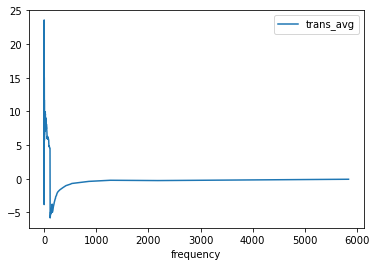

In [72]:
merchant_data.plot(x="frequency",y="trans_avg")

In [73]:
# The average number of merchants that receive negative average transactions
negative = 0
for i in range(len(merchant_data)):
    if merchant_data.trans_avg[i]<0:
        negative += 1
        
negativ_avg = negative/len(merchant_data)

negativ_avg

0.061862678450033994

In [74]:
merchant_data

,trans_avg,frequency
merchant_name,,
amazon uk marketplace,-7.646016e-02,5837
amazon uk retail,-2.717117e-01,2182
travelodge website,-2.275435e-01,1270
asda home shopping,-3.933832e-01,858
amazon uk retail amazon.c,-6.490717e-01,583
...,...,...
bootsferndown,3.149553e-02,1
estimote.com,-4.505672e-03,1
rapid racking ltd,1.786736e-01,1


Text(0, 0.5, 'Cluster inertia')

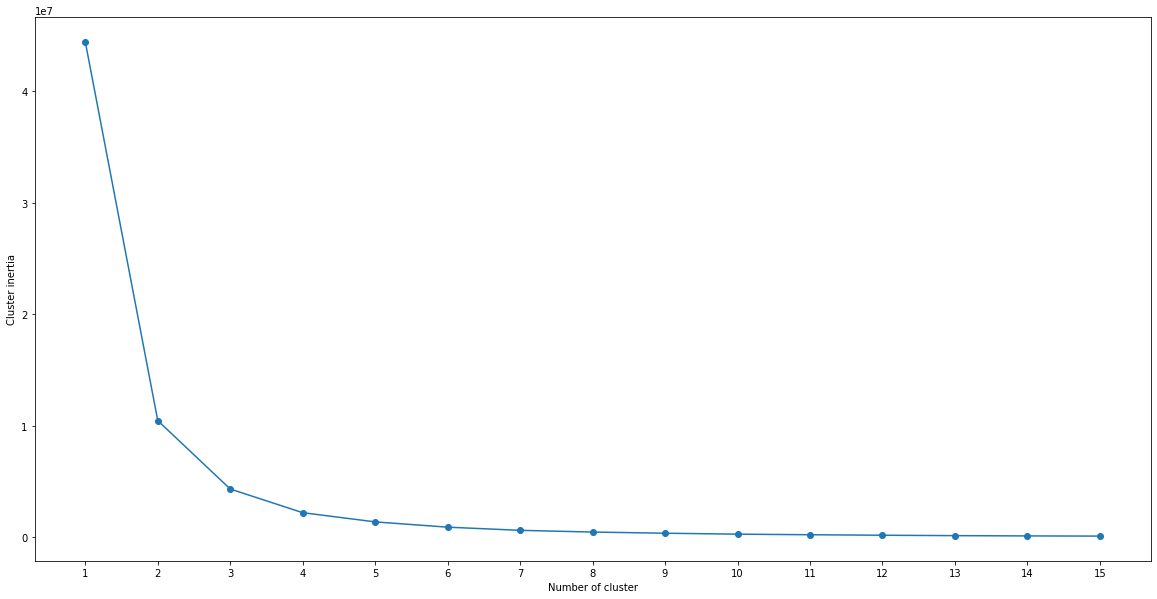

In [75]:
### Here we will do clustering using the KMeans algorithms
# Scaling the frequency of transactions by means amount of transactions
merchant_tr = merchant_data.values

# First we need to determine the optimal number of clusters
cluster_range = range(1,16)
cluster_error = []

for num in cluster_range:
    model = KMeans(num)
    model.fit(merchant_tr)
    cluster_error.append(model.inertia_)

df_clust = pd.DataFrame({'cluster_number':cluster_range,'cluster_error':cluster_error})


plt.figure(figsize=(20,10))
plt.xticks(range(1,16))
plt.plot(df_clust.cluster_number,df_clust.cluster_error, marker="o")
plt.xlabel("Number of cluster")
plt.ylabel("Cluster inertia")

In [76]:
merchant_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5884 entries, amazon uk marketplace to paypal netsolution
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   trans_avg  5884 non-null   float64
 1   frequency  5884 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 137.9+ KB


In [77]:
merchant_data

,trans_avg,frequency
merchant_name,,
amazon uk marketplace,-7.646016e-02,5837
amazon uk retail,-2.717117e-01,2182
travelodge website,-2.275435e-01,1270
asda home shopping,-3.933832e-01,858
amazon uk retail amazon.c,-6.490717e-01,583
...,...,...
bootsferndown,3.149553e-02,1
estimote.com,-4.505672e-03,1
rapid racking ltd,1.786736e-01,1


In [78]:
kmeans_model.cluster_centers_

array([[  9.17358156,  48.85555556],
       [  0.6426004 , 231.02564103],
       [  1.11188582, 110.81294964],
       [  3.93792865,  11.39355993]])

Text(0, 0.5, 'The average transaction made by each merchant')

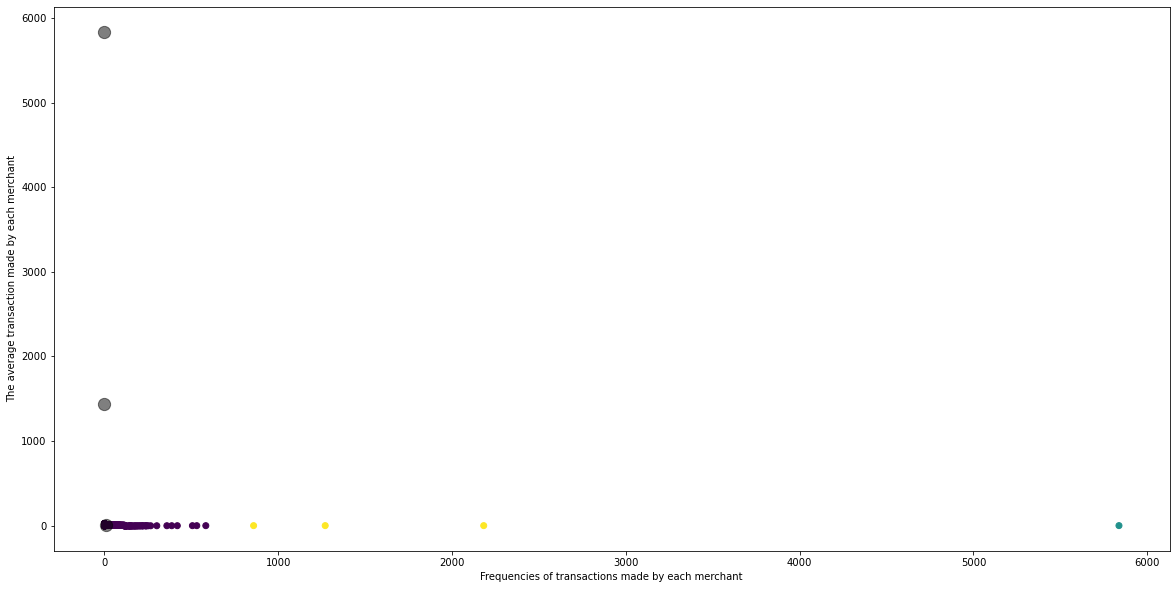

In [79]:
# The elbow graph showed us that 4 clusters is the optimal number
# so we'll start implementing the code

kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(merchant_tr)
kmeans_predict = kmeans_model.predict(merchant_tr)
kmeans_centroids = kmeans_model.cluster_centers_

plt.figure(figsize=(20,10))
plt.scatter(merchant_data['frequency'].values,merchant_data['trans_avg'].values, c=kmeans_predict)
plt.scatter(kmeans_centroids[:,0], kmeans_centroids[:,1], c='black', s=150, alpha=0.5)
plt.xlabel('Frequencies of transactions made by each merchant')
plt.ylabel('The average transaction made by each merchant')

### One-Class SVM

In [81]:
df_aux.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43973 entries, 2015-06-25 to 2017-01-02
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TRANS VAT DESC      43973 non-null  object 
 1   ORIGINAL GROSS AMT  43973 non-null  float64
 2   MERCHANT NAME       43973 non-null  object 
 3   CARD NUMBER         43973 non-null  object 
 4   TRANS CAC CODE 1    43973 non-null  object 
 5   TRANS CAC DESC 1    43973 non-null  object 
 6   TRANS CAC CODE 2    43973 non-null  object 
 7   TRANS CAC DESC 2    43973 non-null  object 
 8   TRANS CAC CODE 3    43973 non-null  object 
 9   Directorate         43973 non-null  object 
dtypes: float64(1), object(9)
memory usage: 3.7+ MB


<AxesSubplot:xlabel='TRANS DATE'>

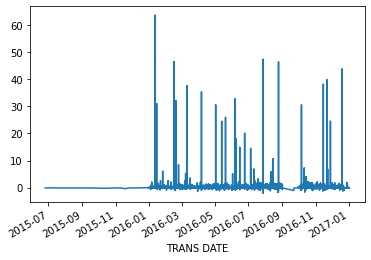

In [82]:
df_aux['ORIGINAL GROSS AMT'].plot()

In [83]:
# Splitting the ORIGINAL GROSS AMOUNT time series data into training and testing datasets (70%+30%)

train_set = df_aux['2016-01' : '2016-09']
test_set = df_aux['2016-09' : ]

<AxesSubplot:xlabel='TRANS DATE'>

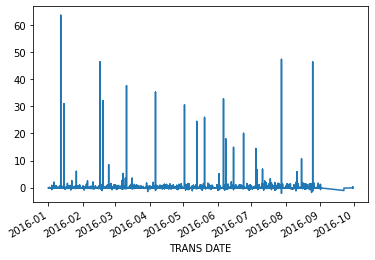

In [84]:
train_set['ORIGINAL GROSS AMT'].plot()

<AxesSubplot:xlabel='TRANS DATE'>

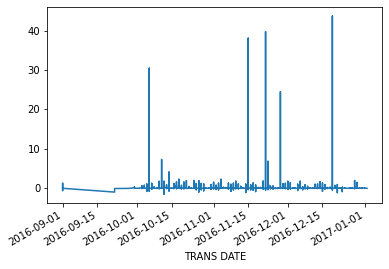

In [85]:
test_set['ORIGINAL GROSS AMT'].plot()

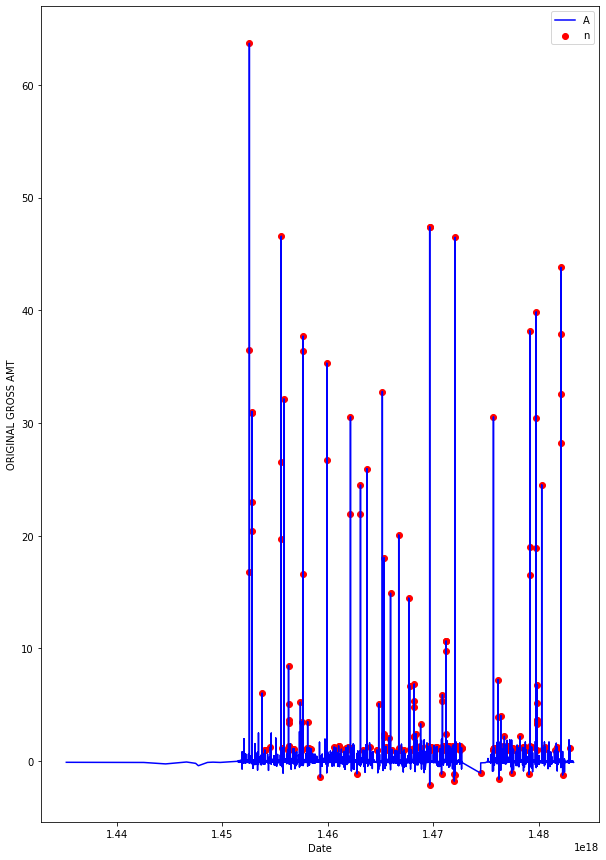

In [86]:
# Training the One-Class SVM model 

ocsvm_model = OneClassSVM(gamma ="auto",nu=0.0025).fit(df_aux['ORIGINAL GROSS AMT'].values.reshape(-1,1))
ocsvm_model.predict(df_aux['ORIGINAL GROSS AMT'].values.reshape(-1,1))
ocsvm_decision_func = ocsvm_model.decision_function(df_aux['ORIGINAL GROSS AMT'].values.reshape(-1,1))
ocsvm_score = ocsvm_model.score_samples(df_aux['ORIGINAL GROSS AMT'].values.reshape(-1,1))

df_aux['INT_TIME'] = df_aux.index.astype(np.int64)
df_aux['ocsvm_decis_func'] = ocsvm_decision_func
anomaly = df_aux.loc[df_aux['ocsvm_decis_func']<0, ['INT_TIME','ORIGINAL GROSS AMT']]
normal = df_aux.loc[df_aux['ocsvm_decis_func']>=0, ['INT_TIME','ORIGINAL GROSS AMT']]

fig, ax = plt.subplots(figsize=(10,15))
ax.plot(df_aux['INT_TIME'],df_aux['ORIGINAL GROSS AMT'], color='blue',label='Normal')
ax.scatter(anomaly['INT_TIME'],anomaly['ORIGINAL GROSS AMT'], color='red', label='Anomaly')

plt.xlabel('Date')
plt.ylabel('ORIGINAL GROSS AMT')
plt.legend('Anomaly detection using OCSVM')
plt.show()

In [87]:
anomaly_fraction = len(anomaly)/len(df_aux['ORIGINAL GROSS AMT'])
anomaly_fraction

0.00543515338957997

# 5 - Forecasting future transactional behavior

<AxesSubplot:xlabel='TRANS DATE'>

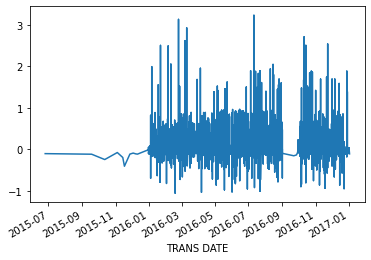

In [88]:
normal['ORIGINAL GROSS AMT'].plot()

<AxesSubplot:xlabel='TRANS DATE'>

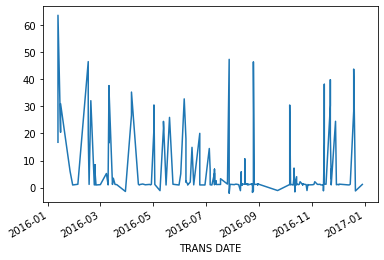

In [89]:
anomaly['ORIGINAL GROSS AMT'].plot()

In [90]:
# splitting training set and test test ona 70%:30% basis from the normal dataset extracted from oncsvm anomaly detection
normal_original_gross_amt = normal['ORIGINAL GROSS AMT']

train_set = normal['2016-01' : '2016-09']
test_set = normal['2016-09' : ]

<AxesSubplot:xlabel='TRANS DATE'>

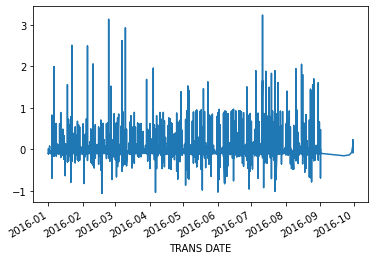

In [91]:
train_set['ORIGINAL GROSS AMT'].plot()

<AxesSubplot:xlabel='TRANS DATE'>

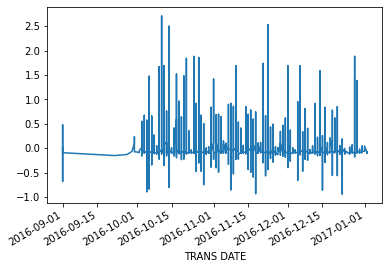

In [92]:
test_set['ORIGINAL GROSS AMT'].plot()

936, expected=-0.075448
predicted=-0.075448, expected=-0.094655
predicted=-0.094655, expected=-0.104474
predicted=-0.104474, expected=-0.069380
predicted=-0.069380, expected=-0.090760
predicted=-0.090760, expected=-0.088724
predicted=-0.088724, expected=-0.001582
predicted=-0.001582, expected=-0.084772
predicted=-0.084772, expected=-0.067559
predicted=-0.067559, expected=-0.090258
predicted=-0.090258, expected=-0.081193
predicted=-0.081193, expected=-0.056356
predicted=-0.056356, expected=-0.061556
predicted=-0.061556, expected=-0.063973
predicted=-0.063973, expected=-0.091944
predicted=-0.091944, expected=-0.070427
predicted=-0.070427, expected=-0.063700
predicted=-0.063700, expected=-0.069631
predicted=-0.069631, expected=-0.123494
predicted=-0.123494, expected=-0.062179
predicted=-0.062179, expected=-0.076136
predicted=-0.076136, expected=-0.017569
predicted=-0.017569, expected=-0.066397
predicted=-0.066397, expected=-0.052648
predicted=-0.052648, expected=-0.078453
predicted=-0.078

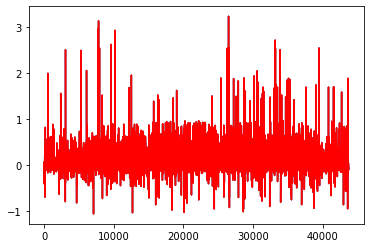

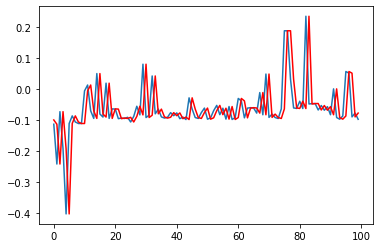

In [93]:
series = normal['ORIGINAL GROSS AMT']

X = series.values
window = 1
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
# zoom plot
plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red')
plt.show()

In [95]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(train_set['ORIGINAL GROSS AMT'])

(0.01, False)

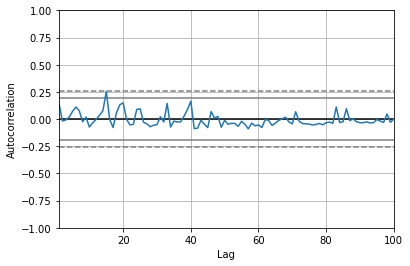

<Figure size 1800x1440 with 0 Axes>

In [99]:
# Forecasting using the ARIMA model
autocorrelation_plot(train_set['ORIGINAL GROSS AMT'][0:100])
plt.figure(figsize=(25,20))
plt.show()

In [102]:
#avoiding jupyter crash because the next step is very hard
notebook_export_variables()

In [104]:
arima_model = auto_arima(train_set['ORIGINAL GROSS AMT'], start_p = 1, d = 0, start_q = 5, 
			 max_p = 2, max_d = 1, max_q = 7, start_P = 2,
			 max_Q = 2, m = 12, seasonal = True,
			 error_action = 'warn', trace = True,
			 supress_warnings = True, setpwise = True,
			 random_state = 20, n_fits = 50 )

Performing stepwise search to minimize aic
 ARIMA(1,0,5)(2,0,1)[12] intercept   : AIC=-31406.220, Time=319.17 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-30865.156, Time=6.34 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-31152.620, Time=22.83 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-31125.746, Time=18.17 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-29160.527, Time=1.78 sec
 ARIMA(1,0,5)(1,0,1)[12] intercept   : AIC=-31404.257, Time=177.55 sec
 ARIMA(1,0,5)(2,0,0)[12] intercept   : AIC=-31408.645, Time=260.74 sec
 ARIMA(1,0,5)(1,0,0)[12] intercept   : AIC=-31411.485, Time=126.08 sec
 ARIMA(1,0,5)(0,0,0)[12] intercept   : AIC=-31412.791, Time=89.18 sec
 ARIMA(1,0,5)(0,0,1)[12] intercept   : AIC=-31411.522, Time=174.25 sec
 ARIMA(0,0,5)(0,0,0)[12] intercept   : AIC=-31323.155, Time=59.74 sec
 ARIMA(1,0,4)(0,0,0)[12] intercept   : AIC=-31404.643, Time=85.18 sec
 ARIMA(2,0,5)(0,0,0)[12] intercept   : AIC=-31411.454, Time=91.41 sec
 ARIMA(1,0,6)(0,0,0)[12] intercept   : AIC=-

In [109]:
arima_model_fit = arima_model.fit(train_set['ORIGINAL GROSS AMT'])

In [121]:
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                31814
Model:               SARIMAX(1, 0, 5)   Log Likelihood               15714.396
Date:                Wed, 03 Feb 2021   AIC                         -31412.791
Time:                        11:44:04   BIC                         -31345.850
Sample:                             0   HQIC                        -31391.372
                              - 31814                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0080      0.001    -11.155      0.000      -0.009      -0.007
ar.L1          0.7715      0.018     43.273      0.000       0.737       0.806
ma.L1         -0.6874      0.018    -38.122      0.000      -0.723      -0.652
ma.L2         -0.0155      0.004     -4.036      0.000      -0.023      -0.008
ma.L3         -0.0113      0.004     -2.652      0.008      -0.020      -0.003
ma.L4          0.0126      0.005      2.678      0.007       0.003       0.022
ma.L5          0.0247      0.003      7.405      0.000       0.018       0.031
sigma2         0.0218   3.77e-05    578.266      0.000       0.022       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):          10868455.83
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             6.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        92.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

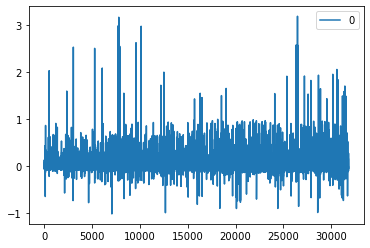

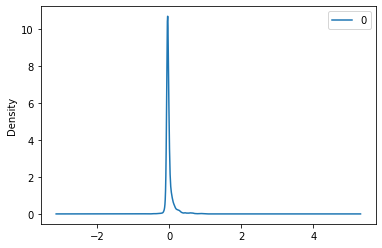

                  0
count  31814.000000
mean       0.000020
std        0.147656
min       -1.022551
25%       -0.051326
50%       -0.034640
75%       -0.001166
max        3.196336


In [125]:
residuals = pd.DataFrame(arima_model_fit.resid())
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [134]:
auto_arima_predictions = pd.DataFrame()
auto_arima_predictions['ORIGINAL GROSS AMT'] = test_set['ORIGINAL GROSS AMT']
auto_arima_predictions['predicted'] = arima_model_fit.predict(n_periods = len(test_set['ORIGINAL GROSS AMT']))
auto_arima_predictions

,ORIGINAL GROSS AMT,predicted
TRANS DATE,,
2016-09-01,0.004163,-0.029939
2016-09-01,-0.052461,-0.029175
2016-09-01,-0.093450,-0.025463
2016-09-01,-0.040807,-0.021625
2016-09-01,-0.094856,-0.026034
...,...,...
2017-01-02,-0.087755,-0.034994
2017-01-02,-0.085898,-0.034994
2017-01-02,-0.078969,-0.034994


<AxesSubplot:xlabel='TRANS DATE'>

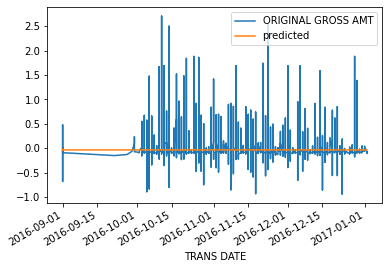

In [135]:
auto_arima_predictions.plot()

In [ ]:
df_aux[['ORIGINAL GROSS AMT','ocsvm_decis_func']]

In [ ]:
df_aux_train = df_aux[['ORIGINAL GROSS AMT','ocsvm_decis_func']].sample(frac=0.7,random_state=0)
df_aux_test = df_aux[['ORIGINAL GROSS AMT','ocsvm_decis_func']].sample(frac=0.3,random_state=0)

In [ ]:
target_scaler_train = MinMaxScaler([0,1])
target_scaler_train.fit(np.array(df_aux_train['ORIGINAL GROSS AMT']).reshape(-1,1))

target_scaler_test = MinMaxScaler([0,1])
target_scaler_test.fit(np.array(df_aux_test['ORIGINAL GROSS AMT']).reshape(-1,1))

In [ ]:
feature_scaler_train = MinMaxScaler([0,1])
feature_scaler_train.fit(np.array(df_aux_train['ocsvm_decis_func']).reshape(-1,1))

feature_scaler_test = MinMaxScaler([0,1])
feature_scaler_test.fit(np.array(df_aux_test['ocsvm_decis_func']).reshape(-1,1))

In [ ]:
# multivariate mlp

 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = df_aux_train['ORIGINAL GROSS AMT'].values
in_seq2 = df_aux_train['ocsvm_decis_func'].values
out_seq = df_aux_train['ORIGINAL GROSS AMT'].values
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

In [ ]:
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 5
# convert into input/output
X, y = split_sequences(dataset, n_steps)

In [ ]:
print(X.shape)
print(y.shape)

In [ ]:
# separate input data
X1 = X[:, :, 0]
X2 = X[:, :, 1]
# first input model
visible1 = Input(shape=(n_steps,))
dense1 = Dense(100, activation='relu')(visible1)
# second input model
visible2 = Input(shape=(n_steps,))
dense2 = Dense(100, activation='relu')(visible2)
# merge input models
merge = concatenate([dense1, dense2])
output = Dense(1)(merge)
model = Model(inputs=[visible1, visible2], outputs=output)
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit([X1, X2], y, epochs=500, verbose=0)

In [ ]:
# demonstrate prediction
# define test input sequence
test_in_seq1 = df_aux_test['ORIGINAL GROSS AMT'].values
test_in_seq2 = df_aux_test['ocsvm_decis_func'].values
test_out_seq = df_aux_test['ORIGINAL GROSS AMT'].values
# convert to [rows, columns] structure
test_in_seq1 = test_in_seq1.reshape((len(test_in_seq1), 1))
test_in_seq2 = test_in_seq2.reshape((len(test_in_seq2), 1))
test_out_seq = test_out_seq.reshape((len(test_out_seq), 1))
# horizontally stack columns
test_dataset = hstack((test_in_seq1, test_in_seq2, test_out_seq))
# choose a number of time steps
n_steps = 5
# convert into input/output
test_X, test_y = split_sequences(test_dataset, n_steps)

In [ ]:
test_X1 = test_X[:, :, 0]
test_X2 = test_X[:, :, 1]

In [ ]:
yhat = model.predict([test_X1, test_X2], verbose=0)
yhat_un = target_scaler_test.inverse_transform(yhat)
print(yhat_un)

In [ ]:
df_aux_test =  df_aux_test.iloc[0:len(yhat_un)]

In [ ]:
df_aux_test['predicted'] = yhat_un

In [ ]:
df_aux_test

In [ ]:
mlp_error = mean_squared_error(df_aux_test['ORIGINAL GROSS AMT'], df_aux_test['predicted'])
print('Test MSE: %.3f' % mlp_error)